<a href="https://colab.research.google.com/github/dmoste/DATA608/blob/master/dmoste_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import io
from zipfile import ZipFile
from urllib.request import urlopen

# Using urllib, zipfile, and io to read in the data set (it was too large for my computer memory to handle)
r = urlopen('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_20v8_csv.zip').read()
file = ZipFile(io.BytesIO(r))
pluto_csv = file.open('pluto_20v8.csv')
nyc = pd.read_csv(pluto_csv, low_memory = False)

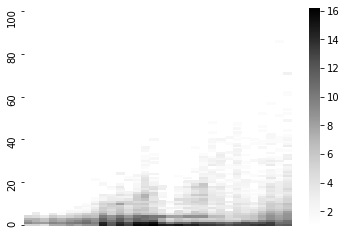

In [5]:
# Basic cleaning to get only the desired years and buildings that have more than 0 floors
nyc = nyc[(nyc['yearbuilt'] > 1850) & (nyc['yearbuilt'] < 2020) & (nyc['numfloors'] != 0)]

# Defining a few key values
year_min = int(nyc['yearbuilt'].min())
year_max = int(nyc['yearbuilt'].max())
floors_max = int(nyc['numfloors'].max())

yearBuilt = pd.cut(nyc['yearbuilt'], np.linspace(year_min, year_max, int((year_max-year_min)/5)))
numFloors = pd.cut(nyc['numfloors'], np.linspace(1, floors_max, floors_max-1))
#numFloors = pd.cut(nyc['numfloors'], [5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120])

cnts = nyc.groupby([numFloors, yearBuilt])['bbl'].count().unstack().fillna(0).values
cnts[cnts == 0] = 1
cnts = np.log2(cnts)

plt = sns.heatmap(cnts, cmap='Greys', mask=(cnts==0), xticklabels=False, yticklabels=20)
plt.invert_yaxis()

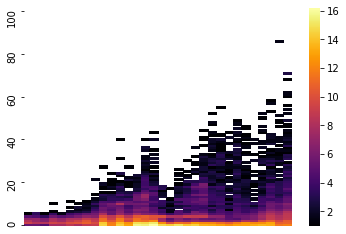

In [224]:
plt = sns.heatmap(cnts, cmap='inferno', mask=(cnts==0), xticklabels=False, yticklabels=20)
plt.invert_yaxis()

In [130]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader import reductions

#from functools import partial
#from datashader.utils import export_image

nyc['assessbuilding'] = nyc['assesstot']-nyc['assessland']
reds = ["#FFFFFF", "#190000", "#320000", "#4B0000", "#640000", "#7D0000", "#960000", "#AF0000", "#C80000", "#E10000", "#FF0000"]
greens = ["#FFFFFF", "#001900", "#003200", "#004B00", "#006400", "#007D00", "#009600", "#00AF00", "#00C800", "#00E100", "#00FF00"]
blues = ["#FFFFFF", "#000019", "#000032","#00004B", "#000064", "#00007D", "#000096", "#0000AF", "#0000C8", "#0000E1", "#0000FF"]

#export = partial(export_image, background = background, export_path="export")

NewYorkCity = ((913164.0, 1067279.0), (120966.0, 272275.0))
small_cvs = ds.Canvas(500, 500, *NewYorkCity)

In [ ]:
# Land value low to high - white to green
small_agg_land = small_cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessland'))
small_land_assess = tf.shade(small_agg_land, cmap = greens, how='eq_hist')

tf.set_background(small_land_assess, 'black')

In [ ]:
# Building value low to high - white to blue
small_agg_building = small_cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessbuilding'))
small_building_assess = tf.shade(small_agg_building, cmap = blues, how='eq_hist')

tf.set_background(small_building_assess, 'black')

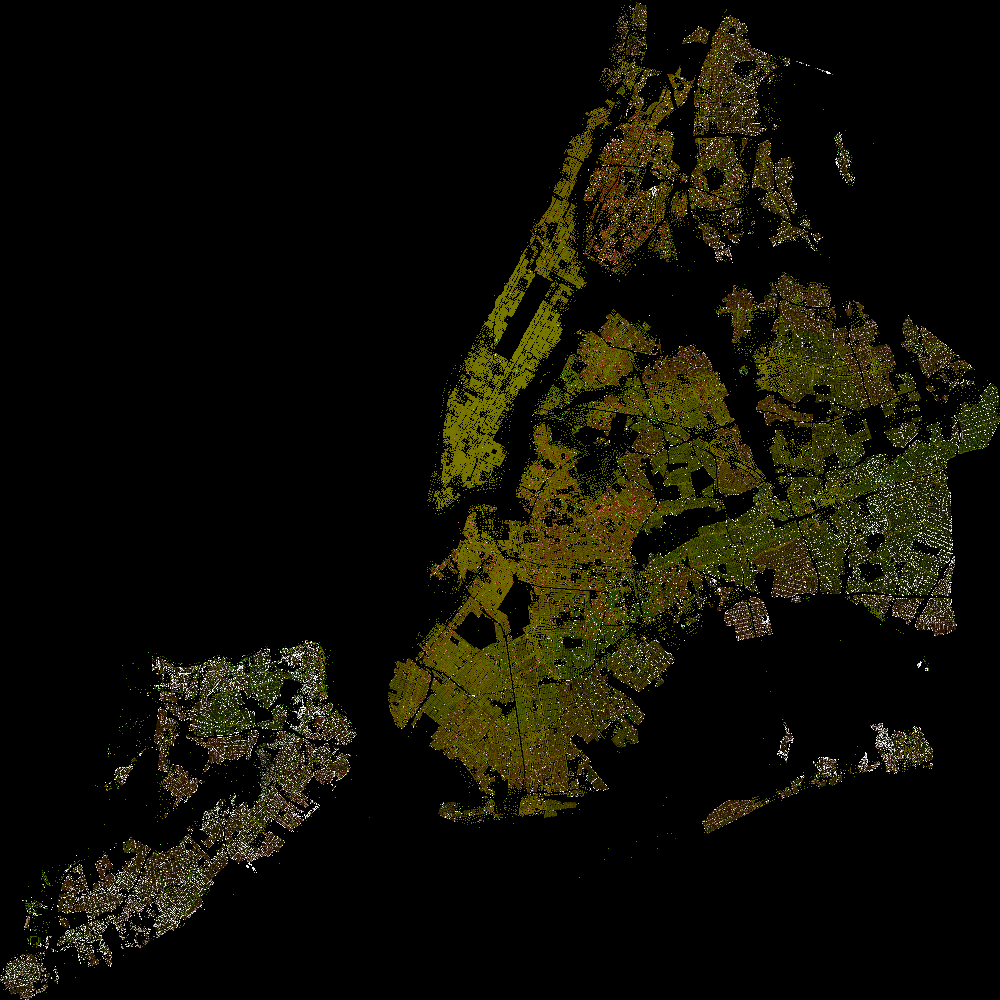

In [133]:
cvs = ds.Canvas(1000, 1000, *NewYorkCity)

agg_land = cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessland'))
land_assess = tf.shade(agg_land, cmap = greens, alpha = 127, how='eq_hist')

agg_building = cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessbuilding'))
building_assess = tf.shade(agg_building, cmap = reds, alpha = 127, how='eq_hist')

tf.set_background(tf.stack(building_assess, land_assess, how = 'add'),'black')